In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.twolink.reaching import TwoLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/twolink/'

In [5]:
# data_train = np.load(savepath+'data_pd_noreg.npy')
# task = TwoLinkReaching(render=True)
# task.visualize_training_data(data_train, 0)

In [6]:
task = TwoLinkReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub
v_lb, v_ub = -100*torch.ones_like(q_lb), 100*torch.ones_like(q_ub)

In [7]:
task.env.set_state(np.zeros(2), np.zeros(2))
task.env.get_state()
pos, orn = p.getLinkState(0, 1, computeForwardKinematics=1)[:2]

In [8]:
from stage.utils.robotics import ForwardKinematics
from stage.tasks.twolink.params import JOINT_XYZ, JOINT_RPY, JOINT_AXIS, LINK_XYZ
fwk = ForwardKinematics(7, JOINT_XYZ, JOINT_RPY, JOINT_AXIS, LINK_XYZ)
q = torch.zeros(1,2)
link_world = fwk(q, 1)
link_pos = link_world[:, :3, 3]
print (link_pos)

tensor([[0.0000, 0.0000, 1.6250]])


In [9]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.trivial import Identity
from stage.controllers.pd import PD

# na = 2
# action_ub = torch.Tensor(task.env.action_space.high)
# action_lb = torch.Tensor(task.env.action_space.low)
# actor = Actor(na, Identity(nq, nv, nu), action_lb, action_ub)

na = 4
gain_ub = 50 * torch.ones((nq))
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(PD(nx, nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor 

In [10]:
# # Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nx, nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size,
                                 learning_rate = 0.001)

dynamics.state_lb = torch.cat((q_lb, v_lb))
dynamics.state_ub = torch.cat((q_ub, v_ub))

In [11]:
# Setup controller

from stage.controllers.pets import PETS

plan_horizon = 100
n_particles = 10
pop_size = 400

controller = PETS(dynamics, task.cost, actor,
                  plan_horizon, n_particles, pop_size)

In [12]:
# Setup learner

from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [13]:
lip_reg = True

if lip_reg:
    controller.regularize(1)
    file_name = savepath + 'data_pd_reg'
else: 
    controller.regularize(0)
    file_name = savepath + 'data_pd_noreg'
    
_ = learner.learn(50, verbose=True)
learner.save_training_data(file_name)

Network training: 100%|██████████| 10/10 [00:00<00:00, 32.26epoch(s)/s, Training loss MSE=2.0993009]


Iteration:  0
Initial state:  tensor([ 2.4050, -0.1807,  0.0000,  0.0000])
avg. decision time:  0.01303060531616211
obs. reward:  -569.88556
act. reward:  -2.3088255


Network training: 100%|██████████| 10/10 [00:00<00:00, 11.35epoch(s)/s, Training loss MSE=0.5952589]


Iteration:  1
Initial state:  tensor([ 2.3929, -0.1564,  0.0000,  0.0000])
avg. decision time:  1.05859934091568
obs. reward:  -566.79535
act. reward:  -0.111033835


Network training: 100%|██████████| 10/10 [00:01<00:00,  8.09epoch(s)/s, Training loss MSE=0.37573963]


Iteration:  2
Initial state:  tensor([2.3541, 0.0090, 0.0000, 0.0000])
avg. decision time:  1.0510294127464295
obs. reward:  -312.82394
act. reward:  -1.2801881


Network training: 100%|██████████| 10/10 [00:01<00:00,  6.28epoch(s)/s, Training loss MSE=0.30135617]


Iteration:  3
Initial state:  tensor([2.3542, 0.0575, 0.0000, 0.0000])
avg. decision time:  1.0581796813011168
obs. reward:  -323.13245
act. reward:  -0.76926166


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.10epoch(s)/s, Training loss MSE=0.26521522]


Iteration:  4
Initial state:  tensor([ 2.4474, -0.1486,  0.0000,  0.0000])
avg. decision time:  1.0566466760635376
obs. reward:  -355.86823
act. reward:  -1.3401299


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.38epoch(s)/s, Training loss MSE=0.43018326]


Iteration:  5
Initial state:  tensor([ 2.4881, -0.1028,  0.0000,  0.0000])
avg. decision time:  1.0606188702583312
obs. reward:  -866.6955
act. reward:  -0.3189856


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.74epoch(s)/s, Training loss MSE=0.34994444]


Iteration:  6
Initial state:  tensor([ 2.3290, -0.0242,  0.0000,  0.0000])
avg. decision time:  1.0584057021141051
obs. reward:  -252.24725
act. reward:  -0.48339278


Network training: 100%|██████████| 10/10 [00:03<00:00,  3.32epoch(s)/s, Training loss MSE=0.34609374]


Iteration:  7
Initial state:  tensor([ 2.2801, -0.0703,  0.0000,  0.0000])
avg. decision time:  1.0611241698265075
obs. reward:  -742.9246
act. reward:  -0.8135043


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.88epoch(s)/s, Training loss MSE=0.31530464]


Iteration:  8
Initial state:  tensor([ 2.5442, -0.0239,  0.0000,  0.0000])
avg. decision time:  1.0581801629066467
obs. reward:  -796.628
act. reward:  -0.3608662


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.60epoch(s)/s, Training loss MSE=0.32600906]


Iteration:  9
Initial state:  tensor([2.3975, 0.0756, 0.0000, 0.0000])
avg. decision time:  1.063988802433014
obs. reward:  -573.4233
act. reward:  -0.44994715


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.38epoch(s)/s, Training loss MSE=0.24070168]


Iteration:  10
Initial state:  tensor([ 2.4783, -0.0771,  0.0000,  0.0000])
avg. decision time:  1.0619931674003602
obs. reward:  -418.13596
act. reward:  -0.6995218


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.20epoch(s)/s, Training loss MSE=0.23815674]


Iteration:  11
Initial state:  tensor([2.3194, 0.1330, 0.0000, 0.0000])
avg. decision time:  1.0616088342666625
obs. reward:  -627.1064
act. reward:  -1.8083909


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.04epoch(s)/s, Training loss MSE=0.23736316]


Iteration:  12
Initial state:  tensor([2.4657, 0.1017, 0.0000, 0.0000])
avg. decision time:  1.0654001545906067
obs. reward:  -645.83923
act. reward:  -1.8200008


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.92epoch(s)/s, Training loss MSE=0.20707464]


Iteration:  13
Initial state:  tensor([ 2.3410, -0.1302,  0.0000,  0.0000])
avg. decision time:  1.0591473364830017
obs. reward:  -199.3265
act. reward:  -0.4354647


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.84epoch(s)/s, Training loss MSE=0.18857946]


Iteration:  14
Initial state:  tensor([ 2.3021, -0.0077,  0.0000,  0.0000])
avg. decision time:  1.0590906739234924
obs. reward:  -170.9043
act. reward:  -0.7287179


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.85epoch(s)/s, Training loss MSE=0.17836507]


Iteration:  15
Initial state:  tensor([ 2.2029, -0.0545,  0.0000,  0.0000])
avg. decision time:  1.059050796031952
obs. reward:  -168.13918
act. reward:  -0.6130048


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.55epoch(s)/s, Training loss MSE=0.16777985]


Iteration:  16
Initial state:  tensor([2.3728, 0.0531, 0.0000, 0.0000])
avg. decision time:  1.0587249064445496
obs. reward:  -153.23819
act. reward:  -1.2799208


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.46epoch(s)/s, Training loss MSE=0.1586837]


Iteration:  17
Initial state:  tensor([2.4619, 0.0556, 0.0000, 0.0000])
avg. decision time:  1.0655535888671874
obs. reward:  -377.7911
act. reward:  -1.8229475


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.47epoch(s)/s, Training loss MSE=0.15044053]


Iteration:  18
Initial state:  tensor([2.2921, 0.0120, 0.0000, 0.0000])
avg. decision time:  1.0627774095535278
obs. reward:  -142.46646
act. reward:  -1.3391259


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.33epoch(s)/s, Training loss MSE=0.16801032]


Iteration:  19
Initial state:  tensor([ 2.2571, -0.0859,  0.0000,  0.0000])
avg. decision time:  1.0620311069488526
obs. reward:  -128.99174
act. reward:  -1.3122323


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.28epoch(s)/s, Training loss MSE=0.13226116]


Iteration:  20
Initial state:  tensor([2.5285, 0.1175, 0.0000, 0.0000])
avg. decision time:  1.0609950256347656
obs. reward:  -412.44278
act. reward:  -0.6007303


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.22epoch(s)/s, Training loss MSE=0.16191214]


Iteration:  21
Initial state:  tensor([ 2.4068, -0.0160,  0.0000,  0.0000])
avg. decision time:  1.0579274463653565
obs. reward:  -158.08575
act. reward:  -1.4608966


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.16epoch(s)/s, Training loss MSE=0.120633796]


Iteration:  22
Initial state:  tensor([ 2.4065, -0.0455,  0.0000,  0.0000])
avg. decision time:  1.0604630184173585
obs. reward:  -390.83142
act. reward:  -0.835566


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.11epoch(s)/s, Training loss MSE=0.12629934]


Iteration:  23
Initial state:  tensor([2.3159, 0.0211, 0.0000, 0.0000])
avg. decision time:  1.0596437978744506
obs. reward:  -362.0114
act. reward:  -0.8644611


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.09epoch(s)/s, Training loss MSE=0.25985953]


Iteration:  24
Initial state:  tensor([ 2.3395, -0.0471,  0.0000,  0.0000])
avg. decision time:  1.0597773957252503
obs. reward:  -181.90736
act. reward:  -1.7703615


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.02epoch(s)/s, Training loss MSE=0.11250999]


Iteration:  25
Initial state:  tensor([2.2848, 0.2900, 0.0000, 0.0000])
avg. decision time:  1.0625522661209106
obs. reward:  -217.55939
act. reward:  -0.4961949


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.00epoch(s)/s, Training loss MSE=0.10636089]


Iteration:  26
Initial state:  tensor([2.3987, 0.0404, 0.0000, 0.0000])
avg. decision time:  1.0588381052017213
obs. reward:  -190.47166
act. reward:  -0.6313884


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.09epoch(s)/s, Training loss MSE=0.10555202]


Iteration:  27
Initial state:  tensor([2.3180, 0.1289, 0.0000, 0.0000])
avg. decision time:  1.0597798705101014
obs. reward:  -164.1628
act. reward:  -0.9093745


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.09s/epoch(s), Training loss MSE=0.11967724]


Iteration:  28
Initial state:  tensor([2.2949, 0.1731, 0.0000, 0.0000])
avg. decision time:  1.0615748858451843
obs. reward:  -151.67079
act. reward:  -2.355885


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.03s/epoch(s), Training loss MSE=0.118684426]


Iteration:  29
Initial state:  tensor([2.1610, 0.0196, 0.0000, 0.0000])
avg. decision time:  1.0639710593223572
obs. reward:  -738.48627
act. reward:  -2.9476285


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.16s/epoch(s), Training loss MSE=0.1472908] 


Iteration:  30
Initial state:  tensor([ 2.4362, -0.1190,  0.0000,  0.0000])
avg. decision time:  1.060631115436554
obs. reward:  -341.47882
act. reward:  -1.0436728


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.17s/epoch(s), Training loss MSE=0.13073988]


Iteration:  31
Initial state:  tensor([ 2.4028, -0.0980,  0.0000,  0.0000])
avg. decision time:  1.0636467456817627
obs. reward:  -171.1099
act. reward:  -0.9828957


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.18s/epoch(s), Training loss MSE=0.101595156]


Iteration:  32
Initial state:  tensor([2.2814, 0.2691, 0.0000, 0.0000])
avg. decision time:  1.0577584433555602
obs. reward:  -156.73325
act. reward:  -1.2791296


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.27s/epoch(s), Training loss MSE=0.11217432]


Iteration:  33
Initial state:  tensor([2.2961, 0.0928, 0.0000, 0.0000])
avg. decision time:  1.0581679296493531
obs. reward:  -150.63873
act. reward:  -1.1654125


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.31s/epoch(s), Training loss MSE=0.10082671]


Iteration:  34
Initial state:  tensor([2.1710, 0.0143, 0.0000, 0.0000])
avg. decision time:  1.0580161905288696
obs. reward:  -159.9448
act. reward:  -0.9303857


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.35s/epoch(s), Training loss MSE=0.0907356] 


Iteration:  35
Initial state:  tensor([2.3520, 0.1038, 0.0000, 0.0000])
avg. decision time:  1.0593742108345032
obs. reward:  -169.33055
act. reward:  -1.0596367


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.39s/epoch(s), Training loss MSE=0.09435275]


Iteration:  36
Initial state:  tensor([ 2.3132, -0.0242,  0.0000,  0.0000])
avg. decision time:  1.059630982875824
obs. reward:  -415.6565
act. reward:  -1.1110063


Network training: 100%|██████████| 10/10 [00:14<00:00,  1.42s/epoch(s), Training loss MSE=0.09833753]


Iteration:  37
Initial state:  tensor([2.3848, 0.0678, 0.0000, 0.0000])
avg. decision time:  1.0589438796043396
obs. reward:  -157.21106
act. reward:  -1.3810828


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.29s/epoch(s), Training loss MSE=0.108456805]


Iteration:  38
Initial state:  tensor([2.2417, 0.0376, 0.0000, 0.0000])
avg. decision time:  1.0610349702835082
obs. reward:  -139.48465
act. reward:  -1.3513216


Network training: 100%|██████████| 10/10 [00:14<00:00,  1.48s/epoch(s), Training loss MSE=0.09381742]


Iteration:  39
Initial state:  tensor([ 2.3811, -0.1105,  0.0000,  0.0000])
avg. decision time:  1.0589198517799376
obs. reward:  -183.97824
act. reward:  -0.6711824


Network training: 100%|██████████| 10/10 [00:15<00:00,  1.53s/epoch(s), Training loss MSE=0.09211654]


Iteration:  40
Initial state:  tensor([2.5147, 0.1816, 0.0000, 0.0000])
avg. decision time:  1.0587244057655334
obs. reward:  -357.31296
act. reward:  -1.3209312


Network training: 100%|██████████| 10/10 [00:15<00:00,  1.58s/epoch(s), Training loss MSE=0.095173046]


Iteration:  41
Initial state:  tensor([ 2.2383, -0.0091,  0.0000,  0.0000])
avg. decision time:  1.066736319065094
obs. reward:  -147.0964
act. reward:  -1.225954


Network training: 100%|██████████| 10/10 [00:15<00:00,  1.59s/epoch(s), Training loss MSE=0.085389584]


Iteration:  42
Initial state:  tensor([2.5130, 0.0274, 0.0000, 0.0000])
avg. decision time:  1.0799378228187562
obs. reward:  -201.44324
act. reward:  -1.3019015


Network training: 100%|██████████| 10/10 [00:16<00:00,  1.64s/epoch(s), Training loss MSE=0.08667171]


Iteration:  43
Initial state:  tensor([2.4952, 0.0317, 0.0000, 0.0000])
avg. decision time:  1.059858500957489
obs. reward:  -385.38956
act. reward:  -0.63821775


Network training: 100%|██████████| 10/10 [00:16<00:00,  1.69s/epoch(s), Training loss MSE=0.08516527]


Iteration:  44
Initial state:  tensor([2.3131, 0.0078, 0.0000, 0.0000])
avg. decision time:  1.0614240336418153
obs. reward:  -144.17091
act. reward:  -1.4878505


Network training: 100%|██████████| 10/10 [00:17<00:00,  1.72s/epoch(s), Training loss MSE=0.08241067]


Iteration:  45
Initial state:  tensor([ 2.4662, -0.0547,  0.0000,  0.0000])
avg. decision time:  1.061978976726532
obs. reward:  -155.36868
act. reward:  -1.4085647


Network training: 100%|██████████| 10/10 [00:17<00:00,  1.75s/epoch(s), Training loss MSE=0.08249823]


Iteration:  46
Initial state:  tensor([ 2.4133, -0.1969,  0.0000,  0.0000])
avg. decision time:  1.061734573841095
obs. reward:  -146.47314
act. reward:  -1.2343905


Network training: 100%|██████████| 10/10 [00:17<00:00,  1.77s/epoch(s), Training loss MSE=0.07886603]


Iteration:  47
Initial state:  tensor([2.2785, 0.0722, 0.0000, 0.0000])
avg. decision time:  1.061692407131195
obs. reward:  -149.49547
act. reward:  -1.207087


Network training: 100%|██████████| 10/10 [00:18<00:00,  1.83s/epoch(s), Training loss MSE=0.08155724]


Iteration:  48
Initial state:  tensor([2.1927, 0.1064, 0.0000, 0.0000])
avg. decision time:  1.0620367550849914
obs. reward:  -138.4759
act. reward:  -1.567138


Network training: 100%|██████████| 10/10 [00:18<00:00,  1.87s/epoch(s), Training loss MSE=0.08158338]

Iteration:  49
Initial state:  tensor([ 2.2197, -0.0383,  0.0000,  0.0000])
avg. decision time:  1.062723400592804
obs. reward:  -150.31306
act. reward:  -1.4685755


In [28]:
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  1.0578596544265748
obs. reward:  -168.49129
act. reward:  -0.9965003


In [29]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(0.2103, grad_fn=<MeanBackward0>)
tensor(0.0919, grad_fn=<StdBackward0>)


In [30]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [31]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [32]:
# traj_pred_mean = np.load('traj_pred_mean.npy')
# traj_pred_std = np.load('traj_pred_std.npy')
# traj = np.load('traj.npy')

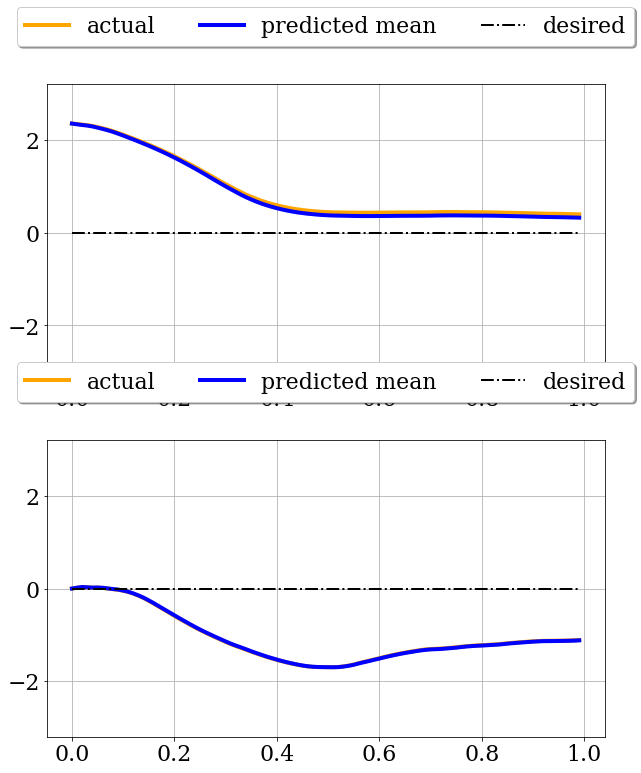

In [33]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
    _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')